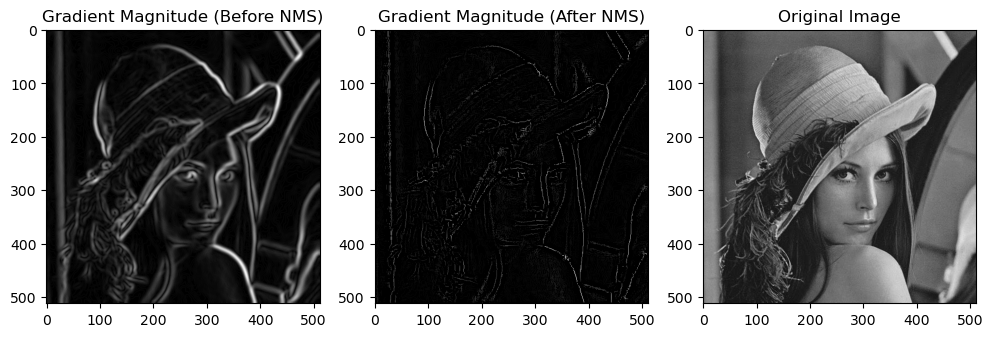

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_gaussian_derivatives(image, sigma=1):
    """
    Compute the x and y derivatives of a Gaussian and the gradient magnitude.

    Parameters:
    - image: Input image (grayscale).
    - sigma: Standard deviation for the Gaussian filter.

    Returns:
    - dx: The x-derivative of the Gaussian.
    - dy: The y-derivative of the Gaussian.
    - gradient_magnitude: The gradient magnitude of the Gaussian.
    """
    # Apply Gaussian smoothing to reduce noise in the image
    blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma, sigmaY=sigma)
    
    # Compute x and y derivatives using the Sobel operator
    dx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)  # x-derivative
    dy = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)  # y-derivative
    
    # Compute gradient magnitude
    gradient_magnitude = cv2.magnitude(dx, dy)
    
    return dx, dy, gradient_magnitude

def non_maximum_suppression(gradient_magnitude, dx, dy):
    """
    Apply non-maximum suppression to thin out edges in the gradient magnitude.

    Parameters:
    - gradient_magnitude: Gradient magnitude of the image.
    - dx: X-derivative of the Gaussian.
    - dy: Y-derivative of the Gaussian.

    Returns:
    - nms_result: Gradient magnitude after non-maximum suppression.
    """
    # Get the dimensions of the gradient magnitude image
    rows, cols = gradient_magnitude.shape
    
    # Initialize the output array for NMS result
    nms_result = np.zeros((rows, cols), dtype=np.float32)
    
    # Calculate the direction of the gradient
    angle = np.arctan2(dy, dx) * (180.0 / np.pi)
    angle = angle % 180  # Convert angle to range [0, 180)
    
    # Apply non-maximum suppression by iterating through the image
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # Determine the neighboring pixels to compare based on the angle
            q = r = 255  # Initialize out-of-bound values
            
            # Angle between 0° and 22.5° or between 157.5° and 180° (horizontal edge)
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = gradient_magnitude[i, j + 1]
                r = gradient_magnitude[i, j - 1]
            # Angle between 22.5° and 67.5° (diagonal edge, bottom left to top right)
            elif 22.5 <= angle[i, j] < 67.5:
                q = gradient_magnitude[i + 1, j - 1]
                r = gradient_magnitude[i - 1, j + 1]
            # Angle between 67.5° and 112.5° (vertical edge)
            elif 67.5 <= angle[i, j] < 112.5:
                q = gradient_magnitude[i + 1, j]
                r = gradient_magnitude[i - 1, j]
            # Angle between 112.5° and 157.5° (diagonal edge, top left to bottom right)
            elif 112.5 <= angle[i, j] < 157.5:
                q = gradient_magnitude[i - 1, j - 1]
                r = gradient_magnitude[i + 1, j + 1]

            # Suppress non-maximum values
            if (gradient_magnitude[i, j] >= q) and (gradient_magnitude[i, j] >= r):
                nms_result[i, j] = gradient_magnitude[i, j]
            else:
                nms_result[i, j] = 0
    
    return nms_result

# Load images
#roses_path = os.path.join(os.getcwd(), 'data', 'images', 'roses.jpg')
lena_path = os.path.join(os.getcwd(), 'data', 'images', 'lena_color.jpg')

# Load the original images in grayscale
#roses_image = cv2.imread(roses_path, cv2.IMREAD_GRAYSCALE)
image = cv2.imread(lena_path, cv2.IMREAD_GRAYSCALE)

# Set the standard deviation for the Gaussian
sigma = 3

# Step 1: Compute Gaussian derivatives and gradient magnitude
dx, dy, gradient_magnitude = compute_gaussian_derivatives(image, sigma=sigma)

# Step 2: Apply non-maximum suppression
nms_result = non_maximum_suppression(gradient_magnitude, dx, dy)

# Display results
plt.figure(figsize=(12, 8))

# Original gradient magnitude (before NMS)
plt.subplot(1, 3, 1)
plt.title("Gradient Magnitude (Before NMS)")
plt.imshow(gradient_magnitude, cmap='gray')

# Gradient magnitude after non-maximum suppression (NMS)
plt.subplot(1, 3, 2)
plt.title("Gradient Magnitude (After NMS)")
plt.imshow(nms_result, cmap='gray')

# Original Image
plt.subplot(1, 3, 3)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.show()
